In [1]:
import time

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sqlite3

In [2]:
db_conn = sqlite3.connect('database.sqlite')
theCursor = db_conn.cursor()
query = theCursor.execute('select * from ascent;') 
cols = [column[0] for column in query.description]
df_ascent= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

In [3]:
df_user = pd.read_sql_query("SELECT * FROM user", db_conn)

In [4]:
df_grade= pd.read_sql_query("SELECT * FROM grade", db_conn)

In [5]:
def standardize_usa_boulder_ratings(row):
    """Group and standardize V-scale ratings"""
    rating = row.usa_boulders
    if rating == 'VB':
        rating = 'V0-'
    elif rating == 'V3/4':
        rating = 'V3'
    elif rating == 'V4/V5':
        rating = 'V4'
    elif rating == 'V5/V6':
        rating = 'V5'
    elif rating == 'V8/9':
        rating = 'V8'
    row.usa_boulders = rating
    
    return row


# Pre-process raw data
df_grade_processed = (
    df_grade
    .loc[df_grade.usa_boulders != '', :] # filter for climbs with V-scale ratings 
    .apply(standardize_usa_boulder_ratings, axis=1)  # group and standardize V-scale ratings
)
df_ascent_processed = df_ascent.loc[df_ascent.climb_type == 1, :] # filter for bouldering climbs

In [6]:
df_interim = (
    df_ascent_processed
    .merge(df_grade_processed, how='inner', left_on='grade_id', right_on='id', suffixes=('_ascent', '_grade'))
    .loc[:, ['id_ascent', 'id_grade', 'user_id', 'date', 'year', 'usa_boulders', 'name']]  # select relevant columns for project
    .sort_values(by=['user_id', 'date'])
    .reset_index(drop=True)   
)

display(df_interim.head())

,id_ascent,id_grade,user_id,date,year,usa_boulders,name
0,37265,44,1,1010098800,2002,V5,???
1,37266,44,1,1010098800,2002,V5,???
2,47943,21,1,1010703600,2002,V0,highball
3,50176,21,1,1010703600,2002,V0,I'm chevy chase...
4,50179,31,1,1010703600,2002,V1,Classico droga


In [7]:
df_interim.usa_boulders.value_counts()

V6     208324
V8     189771
V5     167684
V4     134821
V7     132964
V3     116335
V9      82071
V10     47864
V1      46051
V2      35202
V11     33223
V0      15117
V12     12430
V0-      7716
V13      5153
V14      1226
V15       229
V16        18
V17         1
Name: usa_boulders, dtype: int64

In [8]:

df_interim_pivot = (
    df_interim
    .groupby(['user_id', 'usa_boulders'])
    .nth(0, dropna=None)  # select first ascent at each level for each climber
    .reset_index()
    .pivot_table(index='user_id', columns='usa_boulders', values='date')
#     .loc[:, ['V0-', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'v11', 'v12', 'v13', 'v14', 'v15']]  # limit analysis to V0- to V10 problems
    .reindex(columns=['V0-', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15'])
    .reset_index()
)

display(df_interim_pivot.head())

usa_boulders,user_id,V0-,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,1,1.019426e+09,1.010704e+09,1.010704e+09,1.019340e+09,1.017529e+09,1.018908e+09,1.010099e+09,1.024265e+09,1.022364e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,9.466812e+08,NaN,9.939384e+08,9.920376e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,9.229176e+08,9.783036e+08,9.229176e+08,988668000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,1.155679e+09,1.155679e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1.428790e+09,1.025820e+09,1.112825e+09,1.003356e+09,8.256348e+08,8.571708e+08,9.470268e+08,9.865080e+08,920242800.0,1.141513e+09,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_clean = (
    df_interim_pivot
    .drop('user_id', axis=1)
)

In [10]:
df_clean.head()

usa_boulders,V0-,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,1.019426e+09,1.010704e+09,1.010704e+09,1.019340e+09,1.017529e+09,1.018908e+09,1.010099e+09,1.024265e+09,1.022364e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,9.466812e+08,NaN,9.939384e+08,9.920376e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,9.229176e+08,9.783036e+08,9.229176e+08,988668000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,1.155679e+09,1.155679e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.428790e+09,1.025820e+09,1.112825e+09,1.003356e+09,8.256348e+08,8.571708e+08,9.470268e+08,9.865080e+08,920242800.0,1.141513e+09,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_clean['v11'].notnull()

KeyError: 'v11'

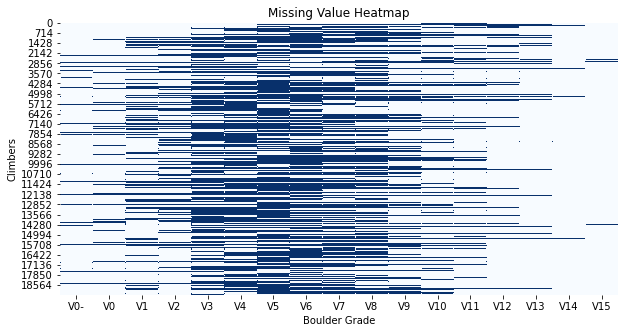

Blue indicates available data
Number of Climbs: 97309
Number Climbers: 19255


In [12]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_clean.notnull().applymap(lambda x: int(x)), cbar=False, cmap='Blues')
plt.title("Missing Value Heatmap")
plt.xlabel("Boulder Grade")
plt.ylabel("Climbers")
plt.show()

print("Blue indicates available data")
print("Number of Climbs: {}".format(df_clean.notnull().sum().sum()))
print("Number Climbers: {}".format(len(df_clean)))

In [13]:
# Compute time spent at each grade
df_clean_diff = (
    df_clean
    .diff(axis=1)
    .applymap(lambda x: np.nan if x < 0 else x)  # remove negative time intervals
    .applymap(lambda x: x / (3600*24*30))  # convert timestamps to months
    .drop('V0-', axis=1)
    .rename(index=str, columns={
        "V0": "V0-", "V1": "V0", "V2": "V1",
        "V3": "V2", "V4": "V3", "V5": "V4",
        "V6": "V5", "V7": "V6","V8": "V7",
        "V9": "V8", "V10": "V9","V11": "V10","V12": "V11","V13": "V12","V14": "V13","V15": "V14"
    })  # shift column labels down a grade to account for diff command
)

# Remove outliers
thresh = df_clean_diff.quantile(q=0.99, axis='index')
mask = df_clean_diff.apply(lambda row: row < thresh.values, axis=1)
df_clean_diff_thresh = df_clean_diff[mask]

display(df_clean_diff_thresh.head())

usa_boulders,V0-,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,NaN,0.0,3.331944,NaN,0.531944,NaN,5.465278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,21.368056,NaN,25.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,33.566667,NaN,NaN,12.166667,34.666667,15.231944,NaN,85.366667,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_clean_diff_thresh[df_clean_diff_thresh['V13'].notnull()]

usa_boulders,V0-,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.166667,NaN,12.100000,10.966667,19.298611,17.268056,NaN
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.198611,NaN,NaN,12.166667,28.831944,33.534722
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.668056,56.731944
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.134722,7.065278,6.168056,23.133333,12.533333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100000,15.400000,NaN,NaN,9.101389,0.266667,6.998611,NaN
18241,37.866667,NaN,35.8,NaN,NaN,0.0,0.2,0.0,0.566667,26.033333,11.933333,NaN,0.933333,0.000000,45.766667,NaN
18471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.133333,0.000000,NaN
18472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.566667,4.166667,12.133333,NaN


In [35]:
vals = (
    df_clean_diff_thresh
#     .rename(index=str, columns={'V0-': '-V0'}) # rename column for plotting purposes
    .rename(index=str, columns={'V0-': 'VB'}) # rename column for plotting purposes
    .mean()
    .cumsum()
)
errs = (
    df_clean_diff_thresh
    .std()
)

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (23).

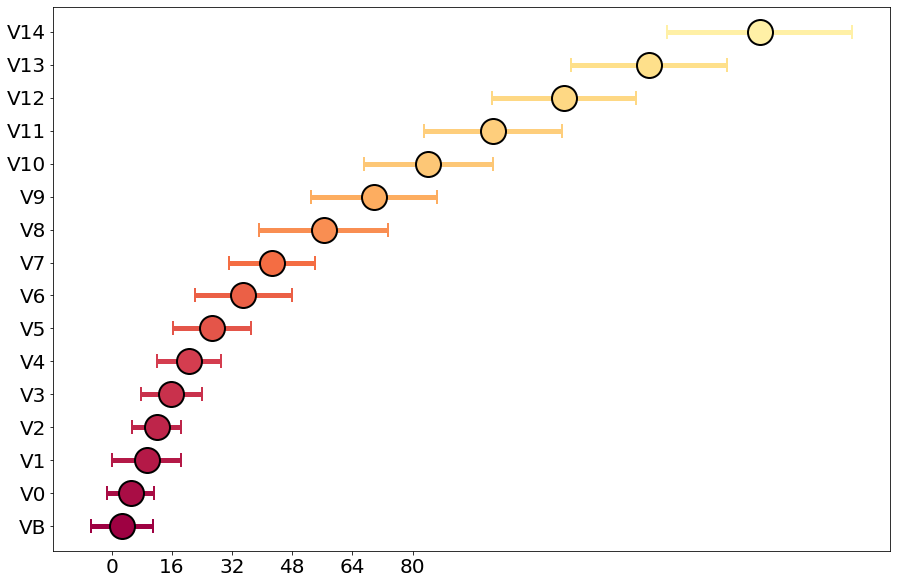

In [36]:
cmap = cm.Spectral
colors = []
colors.extend(cmap(np.linspace(0, 0.1, 6)))
colors.extend(cmap(np.linspace(0.15, 0.2, 3)))
colors.extend(cmap(np.linspace(0.25, 0.3, 2)))
colors.extend(cmap(np.linspace(0.35, 0.4, 4)))
colors.extend(cmap(np.linspace(0.45, 0.5, 1)))

# Create figure
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Creat  Plot
ax.set_facecolor('white')
for i, c in enumerate(colors):    
    plt.errorbar(
        vals[i], 
        i, 
        xerr=errs[i], 
        color=c,
        fmt='o', 
        markersize=25,
        markeredgecolor='black',
        markeredgewidth=2.0,
        linewidth=5,
        ecolor=c,
        capsize=7
    )

# Alter y-axis
plt.yticks(
    np.arange(16),
    vals.index
)
    
# Alter x-axis
plt.xticks(
    np.arange(0, 85, 16),
    ['0', '', '1yr', '', '2yrs', '', '3yrs', '', '4yrs', '', '5yrs', '', '6yrs', '', '7yrs', '', '8yrs', '', '9yrs', '', '10yrs', '', '11yrs' ])
plt.xlim((-0.1, 185))

# Grid
plt.grid(True, axis='y', which='both')
plt.grid(True, axis='x', which='both', linestyle='-', linewidth=1)

# Titles
plt.title("Expected Bouldering Grade\nBased on Time Climbing", fontsize=35)
plt.ylabel("V-Grade", fontsize=35)
plt.xlabel("Time Bouldering Outdoors", fontsize=35)

# Font size
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.show()

print("Plot Values:")
display(vals)

In [37]:
vals

usa_boulders
VB       2.786119
V0       5.049008
V1       9.322904
V2      12.001225
V3      15.892366
V4      20.540404
V5      26.763171
V6      35.010459
V7      42.612512
V8      56.367416
V9      69.817327
V10     84.170312
V11    101.335636
V12    120.140829
V13    142.801959
V14    172.229114
dtype: float64

In [38]:
vals[14]

142.80195929626075

In [39]:
colors

[array([0.61960784, 0.00392157, 0.25882353, 1.        ]),
 array([0.66189927, 0.05082661, 0.26881968, 1.        ]),
 array([0.7041907 , 0.09773164, 0.27881584, 1.        ]),
 array([0.74648212, 0.14463668, 0.288812  , 1.        ]),
 array([0.78877355, 0.19154171, 0.29880815, 1.        ]),
 array([0.83106498, 0.23844675, 0.30880431, 1.        ]),
 array([0.89488658, 0.33348712, 0.28673587, 1.        ]),
 array([0.92349097, 0.37685506, 0.27566321, 1.        ]),
 array([0.95686275, 0.42745098, 0.2627451 , 1.        ]),
 array([0.97485582, 0.557401  , 0.32272203, 1.        ]),
 array([0.99146482, 0.67735486, 0.37808535, 1.        ]),
 array([0.9940792 , 0.77846982, 0.46113033, 1.        ]),
 array([0.99469435, 0.80922722, 0.48696655, 1.        ]),
 array([0.99546328, 0.84767397, 0.51926182, 1.        ]),
 array([0.99607843, 0.87843137, 0.54509804, 1.        ]),
 array([0.99807766, 0.94040754, 0.64905805, 1.        ])]

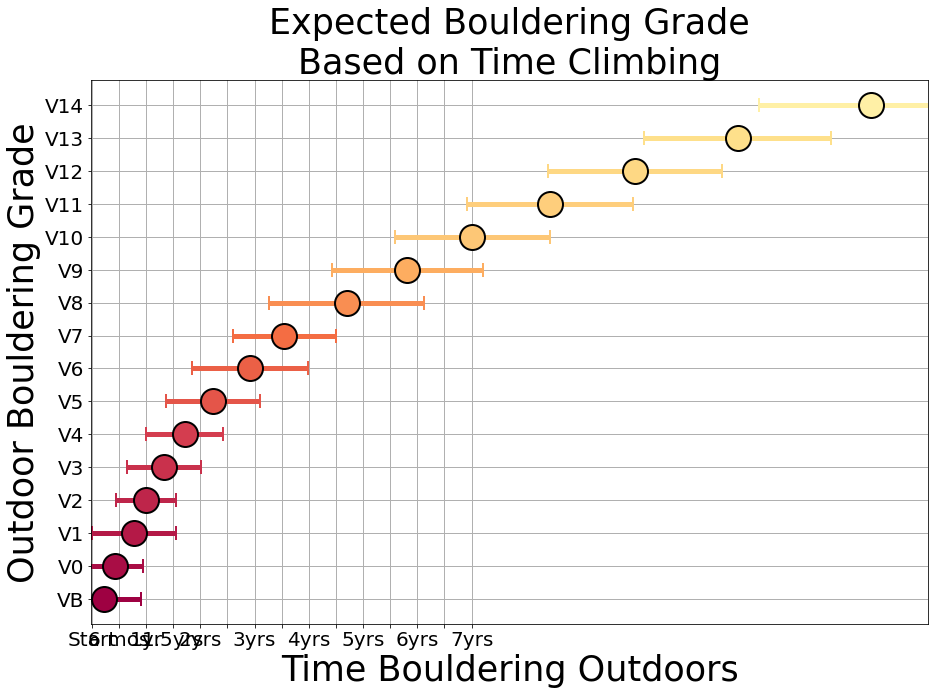

Plot Values:


usa_boulders
VB       2.786119
V0       5.049008
V1       9.322904
V2      12.001225
V3      15.892366
V4      20.540404
V5      26.763171
V6      35.010459
V7      42.612512
V8      56.367416
V9      69.817327
V10     84.170312
V11    101.335636
V12    120.140829
V13    142.801959
V14    172.229114
dtype: float64

In [40]:
cmap = cm.Spectral
colors = []
colors.extend(cmap(np.linspace(0, 0.1, 6)))
colors.extend(cmap(np.linspace(0.15, 0.2, 3)))
colors.extend(cmap(np.linspace(0.25, 0.3, 2)))
colors.extend(cmap(np.linspace(0.35, 0.4, 4)))
colors.extend(cmap(np.linspace(0.45, 0.5, 1)))

# Create figure
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Creat  Plot
ax.set_facecolor('white')
for i, c in enumerate(colors):    
    plt.errorbar(
        vals[i], 
        i, 
        xerr=errs[i], 
        color=c,
        fmt='o', 
        markersize=25,
        markeredgecolor='black',
        markeredgewidth=2.0,
        linewidth=5,
        ecolor=c,
        capsize=7
    )

# Alter y-axis
plt.yticks(
    np.arange(16),
    vals.index
)
    
# Alter x-axis
plt.xticks(
    np.arange(0, 85, 6),
    ['Start', '6 mos', '1yr', '1.5yrs', '2yrs', '', '3yrs', '', '4yrs', '', '5yrs', '', '6yrs', '', '7yrs'])
plt.xlim((-0.1, 185))

# Grid
plt.grid(True, axis='y', which='both', linestyle='-', linewidth=1)
plt.grid(True, axis='x', which='both', linestyle='-', linewidth=1)

# Titles
plt.title("Expected Bouldering Grade\nBased on Time Climbing", fontsize=35)
plt.ylabel("Outdoor Bouldering Grade", fontsize=35)
plt.xlabel("Time Bouldering Outdoors", fontsize=35)

# Font size
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.show()

print("Plot Values:")
display(vals)

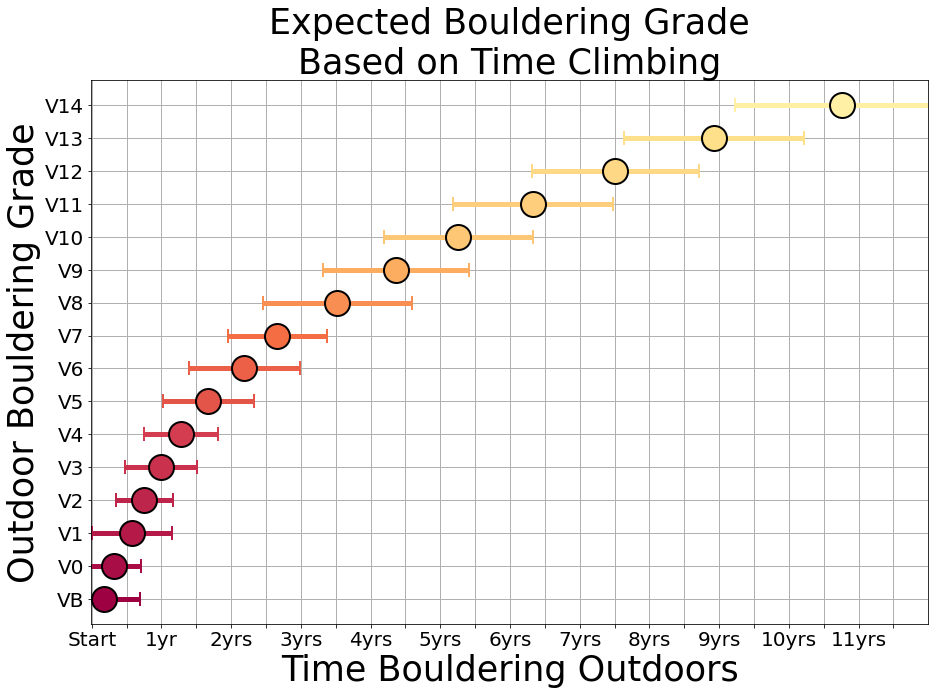

Plot Values:


usa_boulders
VB       2.786119
V0       5.049008
V1       9.322904
V2      12.001225
V3      15.892366
V4      20.540404
V5      26.763171
V6      35.010459
V7      42.612512
V8      56.367416
V9      69.817327
V10     84.170312
V11    101.335636
V12    120.140829
V13    142.801959
V14    172.229114
dtype: float64

In [41]:
cmap = cm.Spectral
colors = []
colors.extend(cmap(np.linspace(0, 0.1, 6)))
colors.extend(cmap(np.linspace(0.15, 0.2, 3)))
colors.extend(cmap(np.linspace(0.25, 0.3, 2)))
colors.extend(cmap(np.linspace(0.35, 0.4, 4)))
colors.extend(cmap(np.linspace(0.45, 0.5, 1)))

# Create figure
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Creat  Plot
ax.set_facecolor('white')
for i, c in enumerate(colors):    
    plt.errorbar(
        vals[i], 
        i, 
        xerr=errs[i], 
        color=c,
        fmt='o', 
        markersize=25,
        markeredgecolor='black',
        markeredgewidth=2.0,
        linewidth=5,
        ecolor=c,
        capsize=7
    )

# Alter y-axis
plt.yticks(
    np.arange(16),
    vals.index
)
    
# Alter x-axis
plt.xticks(
    np.arange(0, 192, 8),
    ['Start', '', '1yr', '', '2yrs', '', '3yrs', '', '4yrs', '', '5yrs', '', '6yrs', '', '7yrs', '', '8yrs', '', '9yrs', '', '10yrs', '', '11yrs', '' ])
plt.xlim((-0.1, 192))

# Grid
plt.grid(True, axis='y', which='both', linestyle='-', linewidth=1)
plt.grid(True, axis='x', which='both', linestyle='-', linewidth=1)

# Titles
plt.title("Expected Bouldering Grade\nBased on Time Climbing", fontsize=35)
plt.ylabel("Outdoor Bouldering Grade", fontsize=35)
plt.xlabel("Time Bouldering Outdoors", fontsize=35)

# Font size
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.show()

print("Plot Values:")
display(vals)

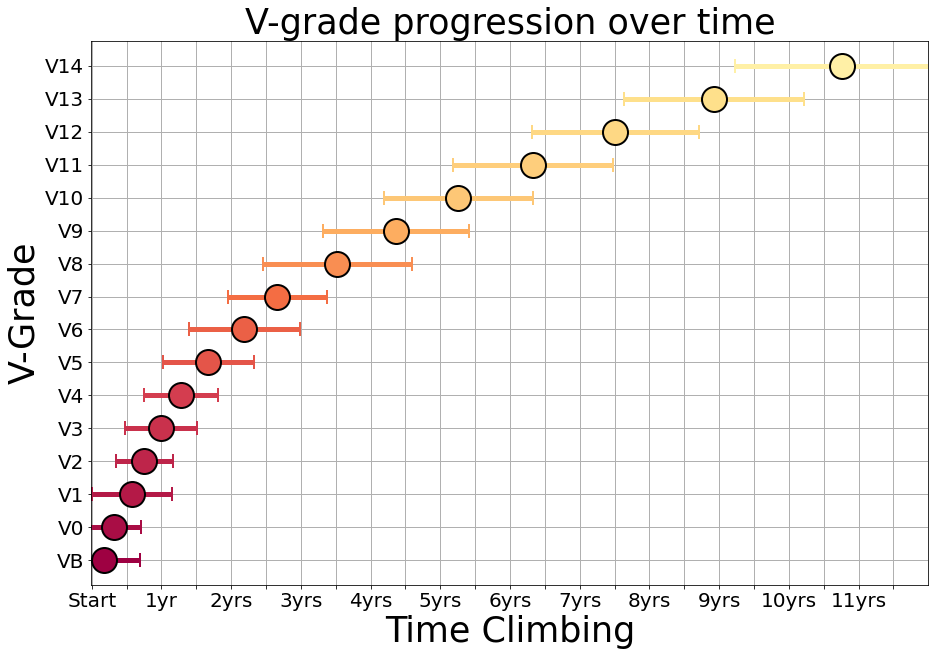

Plot Values:


usa_boulders
VB       2.786119
V0       5.049008
V1       9.322904
V2      12.001225
V3      15.892366
V4      20.540404
V5      26.763171
V6      35.010459
V7      42.612512
V8      56.367416
V9      69.817327
V10     84.170312
V11    101.335636
V12    120.140829
V13    142.801959
V14    172.229114
dtype: float64

In [42]:
cmap = cm.Spectral
colors = []
colors.extend(cmap(np.linspace(0, 0.1, 6)))
colors.extend(cmap(np.linspace(0.15, 0.2, 3)))
colors.extend(cmap(np.linspace(0.25, 0.3, 2)))
colors.extend(cmap(np.linspace(0.35, 0.4, 4)))
colors.extend(cmap(np.linspace(0.45, 0.5, 1)))

# Create figure
plt.figure(figsize=(15, 10))
ax = plt.gca()

# Creat  Plot
ax.set_facecolor('white')
for i, c in enumerate(colors):    
    plt.errorbar(
        vals[i], 
        i, 
        xerr=errs[i], 
        color=c,
        fmt='o', 
        markersize=25,
        markeredgecolor='black',
        markeredgewidth=2.0,
        linewidth=5,
        ecolor=c,
        capsize=7
    )

# Alter y-axis
plt.yticks(
    np.arange(16),
    vals.index
)
    
# Alter x-axis
plt.xticks(
    np.arange(0, 192, 8),
    ['Start', '', '1yr', '', '2yrs', '', '3yrs', '', '4yrs', '', '5yrs', '', '6yrs', '', '7yrs', '', '8yrs', '', '9yrs', '', '10yrs', '', '11yrs', '' ])
plt.xlim((-0.1, 192))

# Grid
plt.grid(True, axis='y', which='both', linestyle='-', linewidth=1)
plt.grid(True, axis='x', which='both', linestyle='-', linewidth=1)

# Titles
plt.title("V-grade progression over time", fontsize=35)
plt.ylabel("V-Grade", fontsize=35)
plt.xlabel("Time Climbing", fontsize=35)

# Font size
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.show()

print("Plot Values:")
display(vals)

In [28]:
def standardize_usa_route_ratings(row):
    """Group and standardize yosemite ratings"""
    rating = row.usa_routes
    if rating == '5.15b/c':
        rating = '5.15b'
    elif rating == '3/4':
        rating = '5.3'
    elif rating == '5.14b/c':
        rating = '5.14b'
    elif rating == '5.14c/d':
        rating = '5.14c'
    elif rating == '5.14d/.15a':
        rating = '5.14d'
    elif rating == '5.15a/b':
        rating = '5.15a'
    row.usa_routes = rating
    
    return row


# Pre-process raw data
df_route_grade_processed = (
    df_grade
    .loc[df_grade.usa_routes != '', :] # filter for climbs with V-scale ratings 
    .apply(standardize_usa_route_ratings, axis=1)  # group and standardize V-scale ratings
)
df_route_ascent_processed = df_ascent.loc[df_ascent.climb_type == 0, :] # filter for bouldering climbs

In [29]:
df_interim_routes = (
    df_route_ascent_processed
    .merge(df_route_grade_processed, how='inner', left_on='grade_id', right_on='id', suffixes=('_ascent', '_grade'))
    .loc[:, ['id_ascent', 'id_grade', 'user_id', 'date', 'year', 'usa_routes', 'name']]  # select relevant columns for project
    .sort_values(by=['user_id', 'date'])
    .reset_index(drop=True)   
)

display(df_interim_routes.head())

,id_ascent,id_grade,user_id,date,year,usa_routes,name
0,18,40,1,913503600,1998,5.10c,Be Careful
1,19,40,1,913935600,1998,5.10c,Monkey Love
2,7,38,1,914022000,1998,5.10b,Valentine
3,20,40,1,914022000,1998,5.10c,Short & Savage
4,35,42,1,914022000,1998,5.10d,Alone


In [30]:
df_interim_routes.usa_routes.value_counts()

5.11d    330978
5.12a    257651
5.12b    228325
5.11a    217328
5.10c    211638
5.11b    198301
5.10a    192575
5.10d    185593
5.12c    174100
5.10b    172785
5.12d    144131
5.13b    108722
5.9      105432
5.13a    101620
5.8       61689
5.13c     46595
5.7       42891
5.4       30145
5.13d     25726
5.14a     11547
5.3        8752
5.14b      5845
5.6        5736
5.5        4078
5.14c      2046
5.14d       724
5.1         555
5.15a       130
5.15b        27
5.15c         7
Name: usa_routes, dtype: int64

In [31]:
df_interim_pivot2 = (
    df_interim_routes
    .groupby(['user_id', 'usa_routes'])
    .nth(0, dropna=None)  # select first ascent at each level for each climber
    .reset_index()
    .pivot_table(index='user_id', columns='usa_routes', values='date')
#     .loc[:, ['V0-', 'V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'v11', 'v12', 'v13', 'v14', 'v15']]  # limit analysis to V0- to V10 problems
    .reindex(columns=['5.1', '5.3', '5.5', '5.6', '5.7', '5.8', '5.9', '5.10a', '5.10b', '5.10c', '5.10d', '5.11a', '5.11b', '5.11c', '5.11d', '5.12a', '5.12b', '5.12c', '5.12d', '5.12a', '5.13a', '5.13b', '5.13c', '5.13d','5.14a', '5.14b', '5.14c', '5.14d', '5.15a', '5.15b', '5.15c'])
    .reset_index()
)

display(df_interim_pivot2.head())

usa_routes,user_id,5.1,5.3,5.5,5.6,5.7,5.8,5.9,5.10a,5.10b,...,5.13b,5.13c,5.13d,5.14a,5.14b,5.14c,5.14d,5.15a,5.15b,5.15c
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.183420e+08,9.140220e+08,...,9.890136e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.334584e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.166569e+09,1.155766e+09,...,1.088633e+09,1.227913e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,1.400796e+09,1.303337e+09,1.396134e+09,1.396649e+09,1.376345e+09,1.303337e+09,1.377727e+09,1.059689e+09,1.178402e+09,...,8.836092e+08,9.571320e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_clean2 = (
    df_interim_pivot2
    .drop('user_id', axis=1)
)

In [33]:
df_clean2.head()

usa_routes,5.1,5.3,5.5,5.6,5.7,5.8,5.9,5.10a,5.10b,5.10c,...,5.13b,5.13c,5.13d,5.14a,5.14b,5.14c,5.14d,5.15a,5.15b,5.15c
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.183420e+08,9.140220e+08,913503600.0,...,9.890136e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,991346400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.334584e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.166569e+09,1.155766e+09,NaN,...,1.088633e+09,1.227913e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.400796e+09,1.303337e+09,1.396134e+09,1.396649e+09,1.376345e+09,1.303337e+09,1.377727e+09,1.059689e+09,1.178402e+09,836172000.0,...,8.836092e+08,9.571320e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing 11c Values

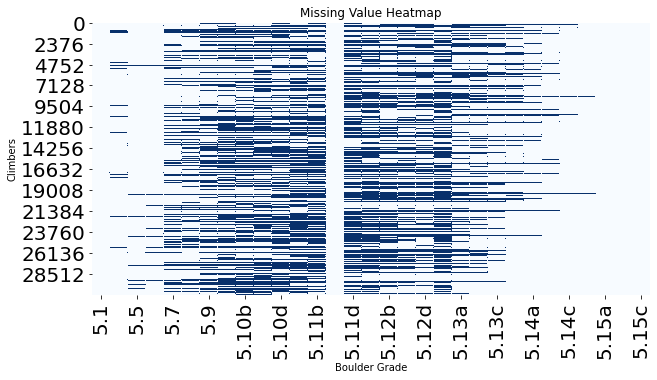

Blue indicates available data
Number of Climbs: 97309
Number Climbers: 19255


In [34]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_clean2.notnull().applymap(lambda x: int(x)), cbar=False, cmap='Blues')
plt.title("Missing Value Heatmap")
plt.xlabel("Boulder Grade")
plt.ylabel("Climbers")
plt.show()

print("Blue indicates available data")
print("Number of Climbs: {}".format(df_clean.notnull().sum().sum()))
print("Number Climbers: {}".format(len(df_clean)))